In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

WS = "/content/drive/My Drive/M2/REDS"
os.chdir(WS)

In [ ]:
from utils import (get_data, 
                   split,
                   oversample,
                   get_cross_val_data,
                   normalise,
                   pool,
                   Timer)
                   

from OnSubsetWrapper import OnSubsetWrapper

In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.base import clone

In [ ]:
RANDOM_SEED = 42

df = get_data()
train_df, test_df = split(df, n_user_test=2, seed = RANDOM_SEED)

/content/drive/My Drive/M2/REDS/utils.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(addr)


In [ ]:
X_train = train_df.drop(["user","target"],axis = 1)
Y_train = train_df.iloc[:,1]
tmp = oversample(test_df)
X_test = tmp.drop(["user","target"],axis = 1)
Y_test =  tmp.iloc[:,1]

In [ ]:
train_df['user'].nunique(), test_df['user'].nunique()

(6, 2)

Split stacking

In [ ]:
train_df1, train_df2 = split(train_df, n_user_test=3, seed = 4)#RANDOM_SEED)

In [ ]:
train_df1['user'].nunique(), train_df2['user'].nunique()
train_df1['user'].unique(), train_df2['user'].unique()

(array([1, 3, 4], dtype=int8), array([5, 7, 8], dtype=int8))

In [ ]:
train_df1.shape, train_df2.shape

((1200, 31), (480, 31))

In [ ]:
X_train1 = train_df1.drop(["user","target"],axis = 1)
Y_train1 = train_df1.iloc[:,1]

X_train2 = train_df2.drop(["user","target"],axis = 1)
Y_train2 = train_df2.iloc[:,1]

### LR with RF trees features

In [ ]:
class LogRegWithDTFeatures:
    def __init__(self, dt_model, log_reg_model):
        self.log_reg = log_reg_model
        self.dt = dt_model
        self.ohe = OneHotEncoder() 
    
    def fit(self, X, y):
        self.dt.fit(X, y)
        self.ohe.fit( self.dt.apply(X) )

        X_dt_features = self.ohe.transform( self.dt.apply(X) )
        self.log_reg.fit( X_dt_features , y)
    
    def predict(self, X, y=None):
        dt_features = self.ohe.transform( self.dt.apply(X) )
        return self.log_reg.predict( dt_features )

    def score(self, X, y):
        return np.mean(self.predict(X).flatten() == y)

In [ ]:
#model = LogRegWithDTFeatures()

ensemble_models = {

    "LrWDTF" : LogRegWithDTFeatures(
        ExtraTreesClassifier(n_estimators=50, random_state=0),
        LogisticRegression(C=0.01)
    )
    

}
acc_df, time_df = pool(ensemble_models, train_df, oversample_train=False)
acc_df

,LrWDTF
mean_train_accuracy,0.9999
mean_val_accuracy,0.8912
prediction_time,0.0200
std_train_accuracy,0.0002
std_val_accuracy,0.0551
training_time,1.6200


### Extra trees + clf sur 24 - 7

In [ ]:
n_estimators_grid = [100, 300]#, 700, 1000, 1500]
bootstrap_grid = [True, False]
max_features_grid = np.linspace(0, 1, 5)[1:]
max_depth_grid = [5, 10, None]#15, None]

ensemble_models = {}

for n_estimators in n_estimators_grid:
    for bootstrap in bootstrap_grid:
        for max_features in max_features_grid:
            for max_depth in max_depth_grid:

                ensemble_models[f'ET n_est_{n_estimators} b_{bootstrap} maxf_{max_features} maxdepth_{max_depth}'] =  ExtraTreesClassifier(
                    n_estimators=n_estimators,
                    bootstrap = bootstrap,
                    max_depth = max_depth,
                    max_features = max_features,
                    random_state=0
                    )

In [ ]:
len(ensemble_models)

48

In [ ]:
%time
acc_df, time_df = pool(ensemble_models, train_df, oversample_train=False)
acc_df

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


,ET n_est_300 b_True maxf_0.25 maxdepth_None,ET n_est_300 b_True maxf_0.5 maxdepth_None,ET n_est_100 b_True maxf_0.25 maxdepth_10,ET n_est_300 b_False maxf_0.25 maxdepth_10,ET n_est_100 b_True maxf_0.25 maxdepth_None,ET n_est_300 b_False maxf_0.25 maxdepth_None,ET n_est_100 b_False maxf_0.75 maxdepth_None,ET n_est_300 b_True maxf_0.25 maxdepth_10,ET n_est_100 b_False maxf_1.0 maxdepth_10,ET n_est_300 b_False maxf_0.75 maxdepth_None,ET n_est_100 b_False maxf_0.25 maxdepth_None,ET n_est_300 b_False maxf_1.0 maxdepth_10,ET n_est_100 b_False maxf_0.25 maxdepth_10,ET n_est_100 b_True maxf_0.5 maxdepth_None,ET n_est_300 b_False maxf_1.0 maxdepth_None,ET n_est_300 b_True maxf_0.75 maxdepth_10,ET n_est_100 b_False maxf_1.0 maxdepth_None,ET n_est_300 b_True maxf_0.5 maxdepth_10,ET n_est_300 b_False maxf_0.5 maxdepth_10,ET n_est_100 b_True maxf_0.5 maxdepth_10,ET n_est_100 b_True maxf_0.75 maxdepth_10,ET n_est_300 b_True maxf_0.75 maxdepth_None,ET n_est_300 b_False maxf_0.5 maxdepth_None,ET n_est_300 b_False maxf_0.75 maxdepth_10,ET n_est_100 b_False maxf_0.5 maxdepth_10,ET n_est_100 b_False maxf_0.75 maxdepth_10,ET n_est_100 b_False maxf_0.5 maxdepth_None,ET n_est_300 b_True maxf_1.0 maxdepth_None,ET n_est_100 b_True maxf_1.0 maxdepth_10,ET n_est_100 b_True maxf_1.0 maxdepth_None,ET n_est_300 b_True maxf_1.0 maxdepth_10,ET n_est_100 b_True maxf_0.75 maxdepth_None,ET n_est_300 b_True maxf_0.5 maxdepth_5,ET n_est_300 b_False maxf_0.5 maxdepth_5,ET n_est_100 b_True maxf_0.5 maxdepth_5,ET n_est_300 b_True maxf_1.0 maxdepth_5,ET n_est_100 b_False maxf_0.25 maxdepth_5,ET n_est_300 b_False maxf_0.25 maxdepth_5,ET n_est_100 b_False maxf_0.5 maxdepth_5,ET n_est_300 b_False maxf_1.0 maxdepth_5,ET n_est_300 b_False maxf_0.75 maxdepth_5,ET n_est_100 b_True maxf_0.25 maxdepth_5,ET n_est_100 b_False maxf_0.75 maxdepth_5,ET n_est_300 b_True maxf_0.75 maxdepth_5,ET n_est_300 b_True maxf_0.25 maxdepth_5,ET n_est_100 b_False maxf_1.0 maxdepth_5,ET n_est_100 b_True maxf_1.0 maxdepth_5,ET n_est_100 b_True maxf_0.75 maxdepth_5
mean_train_accuracy,1.0000,1.0000,0.9988,0.9993,1.0000,1.0000,1.0000,0.9992,0.9997,1.0000,1.0000,0.9997,0.9992,1.0000,1.0000,0.9994,1.0000,0.9993,0.9994,0.9991,0.9993,1.0000,1.0000,0.9995,0.9994,0.9994,1.0000,1.0000,0.9993,1.0000,0.9994,1.0000,0.9426,0.9450,0.9385,0.9407,0.9475,0.9528,0.9405,0.9392,0.9394,0.9470,0.9357,0.9391,0.9492,0.9342,0.9373,0.9326
std_train_accuracy,0.0000,0.0000,0.0007,0.0004,0.0000,0.0000,0.0000,0.0006,0.0003,0.0000,0.0000,0.0003,0.0005,0.0000,0.0000,0.0003,0.0000,0.0004,0.0003,0.0006,0.0004,0.0000,0.0000,0.0003,0.0003,0.0003,0.0000,0.0000,0.0004,0.0000,0.0003,0.0000,0.0132,0.0156,0.0145,0.0135,0.0154,0.0122,0.0181,0.0112,0.0135,0.0147,0.0163,0.0135,0.0123,0.0144,0.0179,0.0178
mean_val_accuracy,0.9179,0.9122,0.9117,0.9109,0.9106,0.9093,0.9064,0.9064,0.9048,0.9044,0.9042,0.9037,0.9025,0.9020,0.9016,0.9013,0.9005,0.9003,0.8994,0.8989,0.8989,0.8986,0.8986,0.8983,0.8980,0.8977,0.8975,0.8968,0.8967,0.8957,0.8949,0.8944,0.8838,0.8824,0.8814,0.8796,0.8784,0.8776,0.8769,0.8759,0.8740,0.8734,0.8733,0.8729,0.8725,0.8696,0.8682,0.8611
std_val_accuracy,0.0606,0.0561,0.0603,0.0612,0.0627,0.0586,0.0714,0.0573,0.0711,0.0648,0.0610,0.0730,0.0610,0.0599,0.0738,0.0632,0.0713,0.0562,0.0595,0.0566,0.0625,0.0644,0.0650,0.0650,0.0582,0.0672,0.0650,0.0660,0.0686,0.0678,0.0700,0.0661,0.0520,0.0574,0.0540,0.0646,0.0573,0.0516,0.0511,0.0711,0.0626,0.0583,0.0641,0.0592,0.0516,0.0638,0.0669,0.0590
training_time,0.7500,0.9500,0.2200,0.7400,0.2700,1.0100,0.4200,0.7100,0.4400,1.2000,0.2700,1.3600,0.2300,0.3200,1.5100,0.9500,0.4500,0.9000,0.9900,0.2900,0.3200,1.0400,1.0600,1.1500,0.3200,0.3500,0.3600,1.1900,0.3700,0.3900,1.1800,0.3300,0.6300,0.7100,0.2100,0.8200,0.1500,0.4500,0.1900,0.8200,0.7400,0.1800,0.2300,0.6500,0.5100,0.2800,0.2400,0.2300
prediction_time,0.0400,0.0500,0.0100,0.0500,0.0200,0.0600,0.0200,0.0500,0.0200,0.0400,0.0200,0.0400,0.0200,0.0200,0.0500,0.0400,0.0100,0.0500,0.0500,0.0100,0.0100,0.0500,0.0500,0.0500,0.0200,0.0100,0

In [ ]:
%time
acc_df, time_df = pool(ensemble_models, train_df1, oversample_train=False)
acc_df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


,ET n_est_300 b_True maxf_0.25 maxdepth_None,ET n_est_300 b_True maxf_0.25 maxdepth_5,ET n_est_100 b_True maxf_0.25 maxdepth_None,ET n_est_300 b_False maxf_0.25 maxdepth_5,ET n_est_300 b_True maxf_0.5 maxdepth_5,ET n_est_100 b_True maxf_0.25 maxdepth_10,ET n_est_100 b_False maxf_0.25 maxdepth_None,ET n_est_300 b_True maxf_0.5 maxdepth_None,ET n_est_300 b_False maxf_0.25 maxdepth_None,ET n_est_100 b_True maxf_0.25 maxdepth_5,ET n_est_300 b_False maxf_0.25 maxdepth_10,ET n_est_300 b_True maxf_0.5 maxdepth_10,ET n_est_100 b_True maxf_0.5 maxdepth_None,ET n_est_300 b_True maxf_0.25 maxdepth_10,ET n_est_100 b_False maxf_0.25 maxdepth_5,ET n_est_100 b_True maxf_0.5 maxdepth_10,ET n_est_100 b_True maxf_0.5 maxdepth_5,ET n_est_300 b_True maxf_0.75 maxdepth_None,ET n_est_300 b_True maxf_1.0 maxdepth_10,ET n_est_300 b_False maxf_1.0 maxdepth_10,ET n_est_300 b_True maxf_1.0 maxdepth_None,ET n_est_300 b_False maxf_0.5 maxdepth_10,ET n_est_300 b_True maxf_0.75 maxdepth_10,ET n_est_300 b_False maxf_0.5 maxdepth_None,ET n_est_100 b_True maxf_1.0 maxdepth_None,ET n_est_100 b_True maxf_1.0 maxdepth_10,ET n_est_100 b_False maxf_0.25 maxdepth_10,ET n_est_100 b_False maxf_0.75 maxdepth_10,ET n_est_300 b_False maxf_0.5 maxdepth_5,ET n_est_300 b_False maxf_0.75 maxdepth_None,ET n_est_100 b_False maxf_0.75 maxdepth_None,ET n_est_300 b_False maxf_1.0 maxdepth_None,ET n_est_100 b_False maxf_0.5 maxdepth_10,ET n_est_100 b_True maxf_0.75 maxdepth_None,ET n_est_100 b_False maxf_1.0 maxdepth_None,ET n_est_300 b_False maxf_0.75 maxdepth_10,ET n_est_100 b_True maxf_1.0 maxdepth_5,ET n_est_100 b_False maxf_0.5 maxdepth_None,ET n_est_100 b_False maxf_1.0 maxdepth_10,ET n_est_300 b_False maxf_0.75 maxdepth_5,ET n_est_100 b_True maxf_0.75 maxdepth_10,ET n_est_100 b_False maxf_0.75 maxdepth_5,ET n_est_300 b_True maxf_0.75 maxdepth_5,ET n_est_100 b_True maxf_0.75 maxdepth_5,ET n_est_300 b_False maxf_1.0 maxdepth_5,ET n_est_100 b_False maxf_0.5 maxdepth_5,ET n_est_300 b_True maxf_1.0 maxdepth_5,ET n_est_100 b_False maxf_1.0 maxdepth_5
mean_train_accuracy,1.0000,0.9889,1.0000,0.9912,0.9847,1.0000,1.0000,1.0000,1.0000,0.9944,1.0000,1.0000,1.0000,1.0000,0.9907,1.0000,0.9898,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9843,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9866,1.0000,1.0000,0.9861,1.0000,0.9880,0.9875,0.9875,0.9875,0.9852,0.9870,0.9861
std_train_accuracy,0.0000,0.0039,0.0000,0.0040,0.0049,0.0000,0.0000,0.0000,0.0000,0.0045,0.0000,0.0000,0.0000,0.0000,0.0069,0.0000,0.0047,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0035,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0024,0.0000,0.0000,0.0039,0.0000,0.0026,0.0034,0.0011,0.0034,0.0047,0.0047,0.0060
mean_val_accuracy,0.9139,0.9083,0.9083,0.9083,0.9069,0.9069,0.9056,0.9042,0.9028,0.9014,0.9000,0.9000,0.8986,0.8986,0.8972,0.8972,0.8958,0.8944,0.8931,0.8917,0.8917,0.8903,0.8903,0.8889,0.8889,0.8889,0.8889,0.8875,0.8875,0.8861,0.8861,0.8847,0.8847,0.8847,0.8847,0.8833,0.8833,0.8833,0.8819,0.8806,0.8806,0.8792,0.8778,0.8764,0.8708,0.8694,0.8667,0.8611
std_val_accuracy,0.0142,0.0068,0.0245,0.0236,0.0071,0.0052,0.0142,0.0034,0.0039,0.0020,0.0068,0.0118,0.0086,0.0137,0.0349,0.0079,0.0090,0.0039,0.0052,0.0118,0.0068,0.0052,0.0071,0.0039,0.0104,0.0104,0.0142,0.0059,0.0270,0.0104,0.0039,0.0052,0.0020,0.0175,0.0168,0.0136,0.0068,0.0068,0.0137,0.0104,0.0079,0.0059,0.0142,0.0187,0.0291,0.0393,0.0204,0.0375
training_time,0.4700,0.4400,0.1500,0.3300,0.4400,0.1600,0.1500,0.4800,0.4300,0.1500,0.3800,0.5200,0.1800,0.4500,0.1100,0.1600,0.1400,0.5300,0.5400,0.5200,0.5500,0.4600,0.5300,0.4200,0.2100,0.2100,0.1400,0.1500,0.3700,0.4900,0.1600,0.5100,0.1600,0.1800,0.1700,0.5000,0.1600,0.1500,0.1700,0.4000,0.1900,0.1400,0.4600,0.1700,0.4300,0.1300,0.4700,0.1400
prediction_time,0.0400,0.0300,0.0100,0.0300,0.0300,0.0100,0.0100,0.0300,0.0400,0.0100,0.0300,0.0400,0.0100,0.0300,0.0100,0.0100,0.0100,0.0300,0.0300,0.0300,0.0300,0.0400,0.0300,0.0300,0.0100,0.0100,0

In [ ]:
%time

n_estimators = 100
bootstrap = False
max_depth = None
max_features = 0.25

x_train1, x_train2 = normalise(X_train1.values, oversample(train_df2.drop(["user","target"],axis = 1)).values)
model = ExtraTreesClassifier(
    n_estimators=n_estimators,
                    bootstrap = bootstrap,
                    max_depth = max_depth,
                    max_features = max_features,
                    random_state=0
)
model.fit(x_train1, Y_train1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

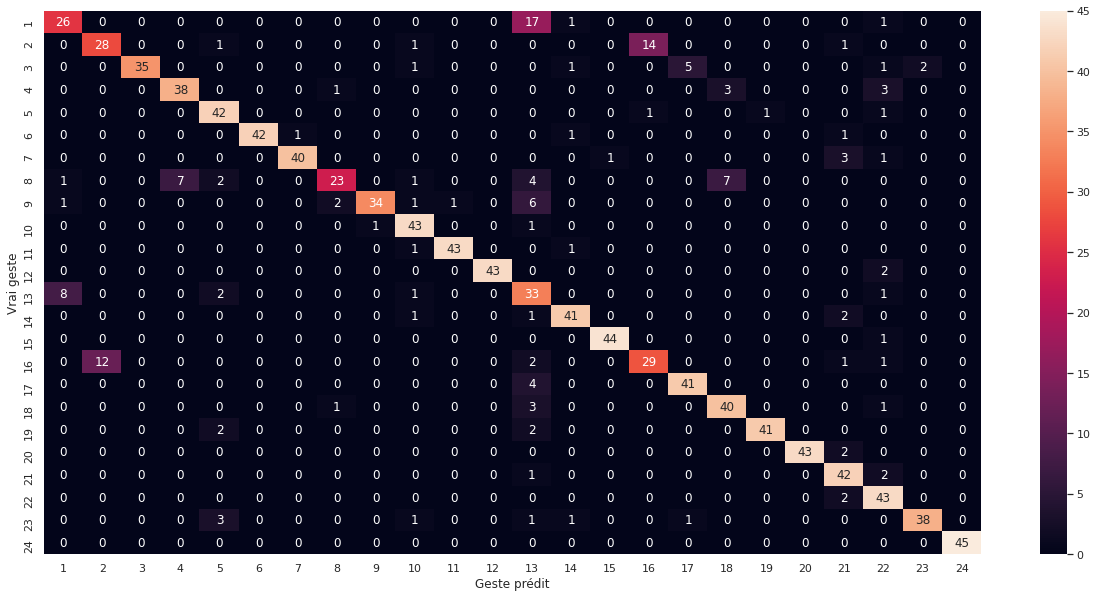

In [ ]:
y_train2_pred = model.predict(x_train2)

data = {'Vrai geste':    (oversample(train_df2)["target"]).values.flatten(),
        'Geste prédit': y_train2_pred.flatten()
        }

df = pd.DataFrame(data, columns=['Vrai geste','Geste prédit'])
confusion_matrix = pd.crosstab(df['Vrai geste'], df['Geste prédit'], rownames=['Vrai geste'], colnames=['Geste prédit'])#, margins = True)
plt.figure(figsize=(21, 10))
sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
model.score(x_train2, Y_train2)

0.8490740740740741